In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = './data/'

fake_df = pd.read_csv(data_dir + 'Fake.csv')
true_df = pd.read_csv(data_dir + 'True.csv')

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true_df.duplicated().sum()

206

In [6]:
fake_df.duplicated().sum()

3

In [7]:
true_df.drop_duplicates(inplace=True)
fake_df.drop_duplicates(inplace=True)

In [8]:
print(fake_df.info())
print(true_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23478 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23478 non-null  object
 1   text     23478 non-null  object
 2   subject  23478 non-null  object
 3   date     23478 non-null  object
dtypes: object(4)
memory usage: 917.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 21211 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21211 non-null  object
 1   text     21211 non-null  object
 2   subject  21211 non-null  object
 3   date     21211 non-null  object
dtypes: object(4)
memory usage: 828.6+ KB
None


# EDA


Let's start with understanding the subjects (or categories) in which the texts we have fall into.

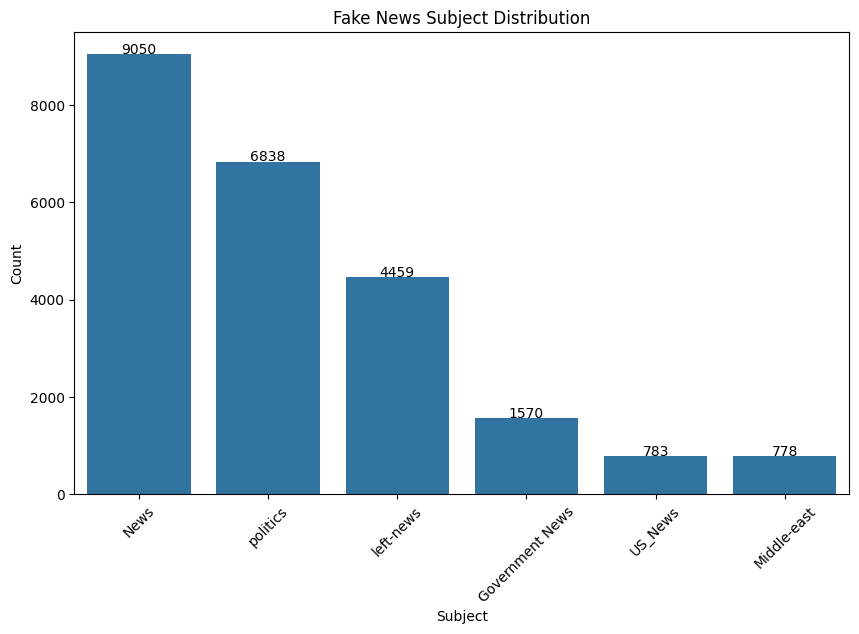

In [9]:
subject_counts = fake_df['subject'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=subject_counts.index, y=subject_counts.values)
plt.title('Fake News Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
for index, value in enumerate(subject_counts):
    plt.text(index, value + 10, str(value), ha='center')

plt.show()

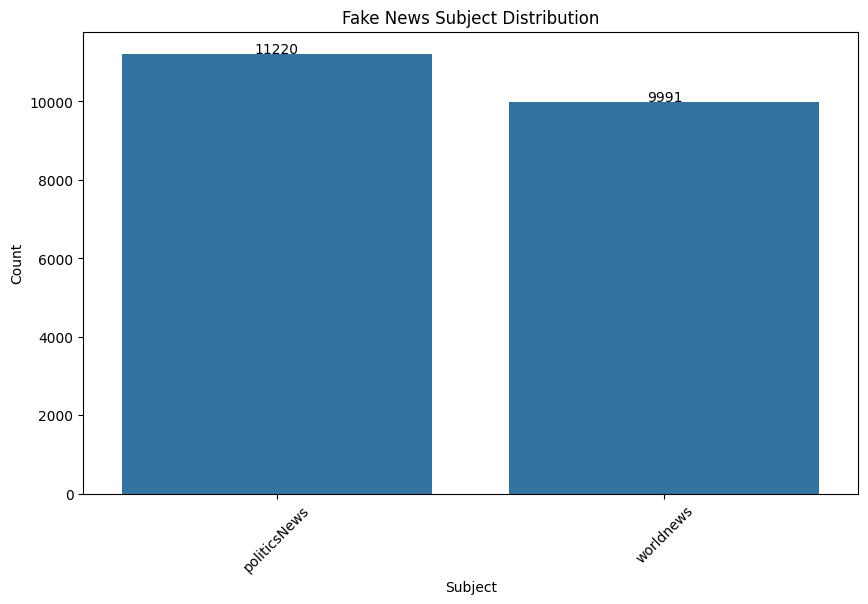

In [10]:
subject_counts = true_df['subject'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=subject_counts.index, y=subject_counts.values)
plt.title('Fake News Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
for index, value in enumerate(subject_counts):
    plt.text(index, value + 10, str(value), ha='center')

plt.show()

We can already see a marked difference here, whereas the fake news articles has varying subjects, the true news articles only have 2 topics. We can later merge these into similar categories.

In [11]:
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def count_tokens(text):
    return len(word_tokenize(text))

fake_df['token_count'] = fake_df['text'].apply(count_tokens)
true_df['token_count'] = true_df['text'].apply(count_tokens)

fake_df['word_count'] = fake_df['text'].apply(lambda x: len(x.split()))
true_df['word_count'] = true_df['text'].apply(lambda x: len(x.split()))

fake_df['sentence_count'] = fake_df['text'].apply(lambda x: len(x.split('.')))
true_df['sentence_count'] = true_df['text'].apply(lambda x: len(x.split('.')))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ITNESALE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


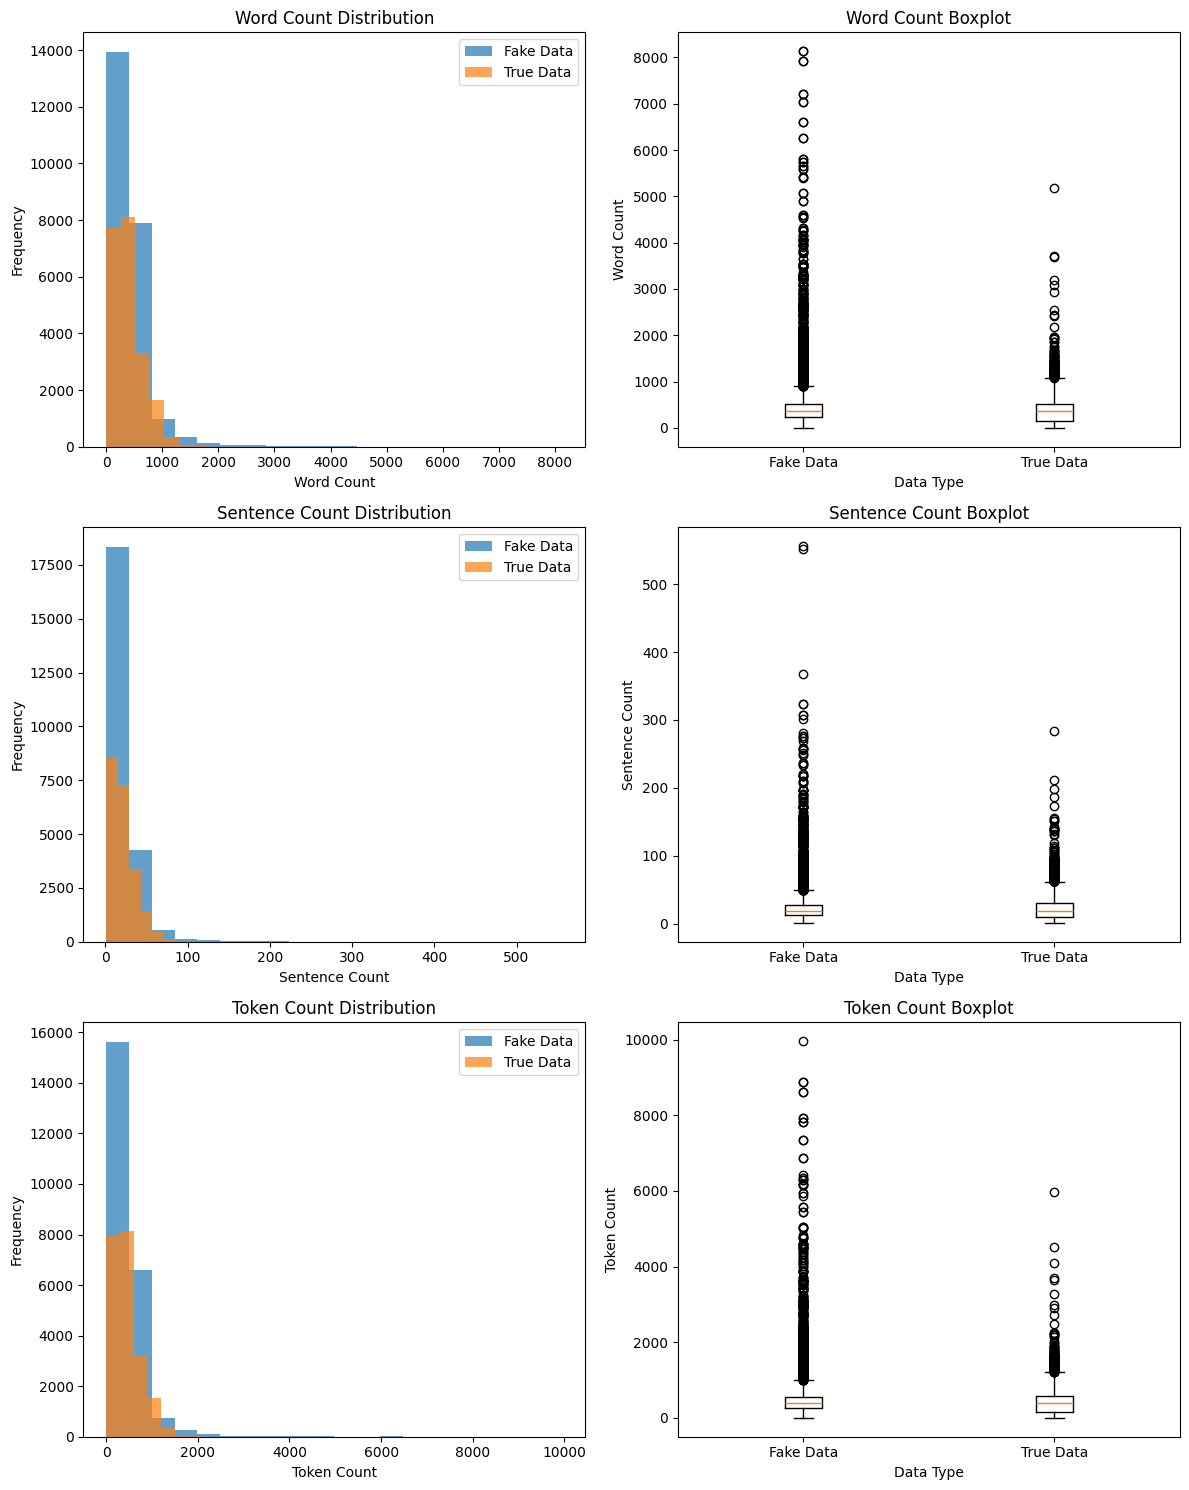

In [12]:
from scripts.stats_and_graphs import plot_text_statistics, compare_columns

plot_text_statistics(fake_df, true_df)

Hmm this is interesting, the average and sentence count in the fake news dataset seems to be higher than in the true news dataset.

The token counts also show a very similar distribution.

I wonder if this difference is statistically significant, we can use a simple t-test wihtout breaking its assumptions given the sheer amount of data we have, to compare the means.

In [13]:
compare_columns(fake_df, true_df, 'word_count')
compare_columns(fake_df, true_df, 'sentence_count')
compare_columns(fake_df, true_df, 'token_count')

t-statistic: 11.5671, p-value: 0.0000
There is a significant difference in 'word_count' between fake and true news.
t-statistic: -0.1870, p-value: 0.8517
There is no significant difference in 'sentence_count' between fake and true news.
t-statistic: 9.5530, p-value: 0.0000
There is a significant difference in 'token_count' between fake and true news.


(9.5529824163956, 1.321512557789629e-21)

So here's the verdict. 

- There is a significant difference (p-value < 0.05) in word counts between fake and true news.
- There is a significant difference (p-value < 0.05) in token counts between fake and true news.
- But there is no significant difference in sentence counts between fake and true news (p-value > 0.05).

We also have data on dates where the news came out. We can take advantage of this later on to create our models, but we need to understand first how the dates are distributed.

In [14]:
fake_df['label'] = 1
true_df['label'] = 0

df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

In [15]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='mixed')

invalid_dates = df[df['date'].isna()]
print("Invalid Date Rows:")
print(invalid_dates)

Invalid Date Rows:
                                                   title  \
1436   https://fedup.wpengine.com/wp-content/uploads/...   
3260   https://fedup.wpengine.com/wp-content/uploads/...   
5373   https://fedup.wpengine.com/wp-content/uploads/...   
7409   https://fedup.wpengine.com/wp-content/uploads/...   
18103                                           Homepage   
20879  https://100percentfedup.com/served-roy-moore-v...   
23460  https://100percentfedup.com/12-yr-old-black-co...   
30663  https://fedup.wpengine.com/wp-content/uploads/...   
42746  https://fedup.wpengine.com/wp-content/uploads/...   
42775  https://100percentfedup.com/video-hillary-aske...   

                                                    text          subject  \
1436   https://fedup.wpengine.com/wp-content/uploads/...  Government News   
3260   https://fedup.wpengine.com/wp-content/uploads/...        left-news   
5373   https://fedup.wpengine.com/wp-content/uploads/...  Government News   
7409   https

In [16]:
df = df.dropna(subset=['date'])
df = df.reset_index(drop=True)

By doing this, we have effectively removed all the unproperly formatted dates in our dataset.

In [17]:
merge_map = {
    'politicsNews': 'Politics',
    'politics': 'Politics',
    'left-news': 'Politics',
    'worldnews': 'World News',
    'Middle-east': 'World News',
    'Government News': 'US News',
    'US_News': 'US News',
    'News': 'General News'
}

df['subject'] = df['subject'].map(merge_map)

Since we have different subjects per news, and some of them are definitely similar/can be conflated into one, we are going to do just so with mappings.

In [18]:
print("Cleaned DataFrame:")
df

Cleaned DataFrame:


,title,text,subject,date,token_count,word_count,sentence_count,label
0,Fox News Confuses Julius Caesar Depiction For...,Fox News loves to point the finger at Snowfla...,General News,2017-06-12,349,320,17,1
1,BOMBSHELL: US General Admits Obama Willingly A...,The idea that our President would arm terroris...,Politics,2015-11-01,300,268,15,1
2,Armed Black Protesters Chase Off Anti-Muslim ...,This is either really funny or a dangerous esc...,General News,2016-04-02,448,411,22,1
3,HUMILIATING: Democrats Use RUSSIAN WARSHIPS As...,Maybe Hillary s Russian uranium deal included ...,Politics,2016-07-29,368,336,23,1
4,No. 2 Senate Republican: health bill to be dis...,"WASHINGTON (Reuters) - Senator John Cornyn, th...",Politics,2017-07-24,80,69,4,0
...,...,...,...,...,...,...,...,...
44674,Trump White House Wishes ‘Lasting Peach’ In T...,"Donald Trump hires all the best people, at lea...",General News,2017-05-22,423,367,17,1
44675,WOW! IS SEAN HANNITY’S Job With FOX News In Je...,"What the heck is going on over at FOX News, th...",Politics,2017-05-23,1146,985,48,1
44676,BREAKING DALLAS: DPD Chief Confirms 10 Officer...,UPDATE 12:09: 1 Suspect in custody. 1 suspect ...,Politics,2016-07-07,499,378,40,1
44677,Trump's concession on wall funding removes obs...,WASHINGTON (Reuters) - The threat of a U.S. go...,Politics,2017-04-25,940,829,42,0


Let's now focus on checking the dates.

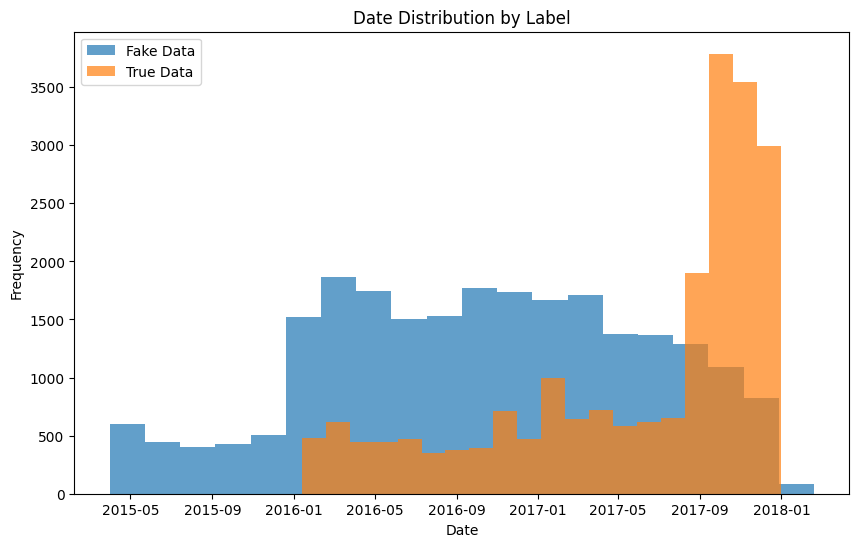

In [19]:
fake_data = df[df['label'] == 1]
true_data = df[df['label'] == 0] 

plt.figure(figsize=(10, 6))
plt.hist(fake_data['date'], bins=20, alpha=0.7, label='Fake Data')
plt.hist(true_data['date'], bins=20, alpha=0.7, label='True Data')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Date Distribution by Label')
plt.legend()

plt.show()

In [20]:
label_year_distribution = df.groupby([df['date'].dt.year, 'label']).size().unstack(fill_value=0)
print("Label Distribution by Year:")
print(label_year_distribution)

Label Distribution by Year:
label      0      1
date               
2015       0   2478
2016    4701  11754
2017   16510   9201
2018       0     35


In [21]:
label_year_month_distribution_df = df.groupby([df['date'].dt.to_period('M'), 'label']).size().unstack(fill_value=0).reset_index()
print("Label Distribution by Year and Month:")
print(label_year_month_distribution_df)

Label Distribution by Year and Month:
label     date     0     1
0      2015-03     0     8
1      2015-04     0   326
2      2015-05     0   338
3      2015-06     0   236
4      2015-07     0   291
5      2015-08     0   220
6      2015-09     0   202
7      2015-10     0   281
8      2015-11     0   275
9      2015-12     0   301
10     2016-01   246  1081
11     2016-02   428  1020
12     2016-03   489  1088
13     2016-04   383   977
14     2016-05   394  1012
15     2016-06   418   871
16     2016-07   337   883
17     2016-08   265   892
18     2016-09   350   936
19     2016-10   334  1082
20     2016-11   635  1004
21     2016-12   422   908
22     2017-01   750  1029
23     2017-02   589   879
24     2017-03   679  1065
25     2017-04   528   805
26     2017-05   504   827
27     2017-06   555   814
28     2017-07   538   777
29     2017-08   651   795
30     2017-09  3062   635
31     2017-10  3157   605
32     2017-11  3081   523
33     2017-12  2416   447
34     2018-02   

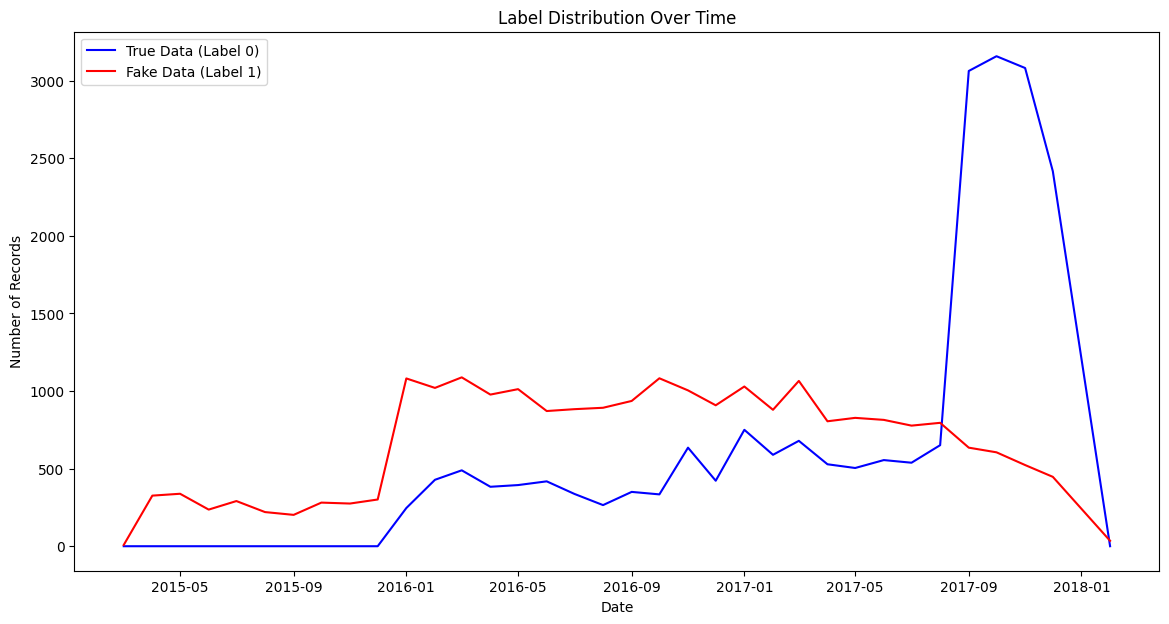

In [22]:
label_distribution = df.groupby([df['date'].dt.to_period('M'), 'label']).size().unstack(fill_value=0).reset_index()
label_distribution['date'] = label_distribution['date'].dt.to_timestamp()

plt.figure(figsize=(14, 7))

plt.plot(label_distribution['date'], label_distribution[0], label='True Data (Label 0)', color='blue')
plt.plot(label_distribution['date'], label_distribution[1], label='Fake Data (Label 1)', color='red')

plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Label Distribution Over Time')
plt.legend()
plt.show()

It's hard to choose on a proper distribution of dates over which to choose. It seems after a certain date, a vast majority of the data is only true data. 

To deal with this, one thing we can do is to use a date before the spike in true data comes through, so to hope that we have more false data. And then manage the weight of the labels to have a balanced result.

Another option is to entirely ignore the date concept, and later when we split data into train and test, oversample the minority class. This can be done because we are only dealing with the engineered features of the text present and not the actual content of it. 

Thus, we are not actually leaking data into the test set by mixing previous and later dates between the sets. The models only look at characteristics such as word length, or sentence counts, which are, as we've seen significantly different between the two labels. 

Let's say now we want to understand which are the most common words used in these two datasets.

First, we need to clean the data a bit. To start off, we will copy the datasets to avoid overwriting them.

In [23]:
from scripts.clean_text_features import plot_wordcloud_and_top_words, calculate_bigrams_and_trigrams

df_2 = df.copy(deep=True)

In [24]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ITNESALE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ITNESALE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ITNESALE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Here is the word cloud for FAKE news.

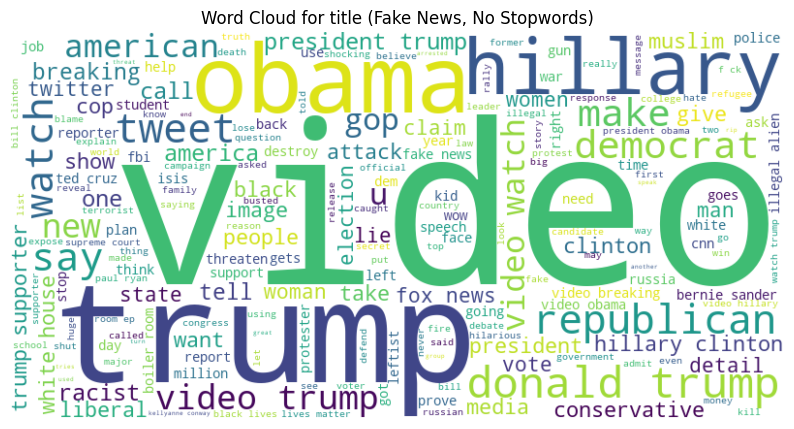

Top 10 Words for title (Fake News):
[('trump', 8694), ('video', 8370), ('obama', 2476), ('hillary', 2187), ('watch', 1901), ('clinton', 1098), ('president', 1089), ('new', 895), ('breaking', 880), ('news', 858)]


In [25]:
filtered_words_fake = plot_wordcloud_and_top_words(df_2, 1, 'Fake News', 'title')

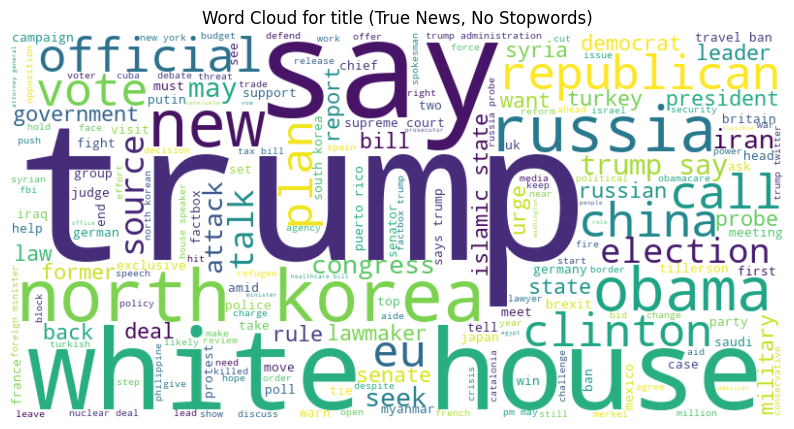

Top 10 Words for title (True News):
[('trump', 5358), ('says', 2962), ('house', 1440), ('north', 911), ('russia', 902), ('korea', 870), ('new', 858), ('white', 804), ('china', 761), ('senate', 756)]


In [26]:
filtered_words_true = plot_wordcloud_and_top_words(df_2, 0, 'True News', 'title')

A very interesting result is that the word 'trump' is the most common word in both fake and true news titles, and it's used more in fake news than true news.

Let's look at the most common bigram and trigrams.

In [27]:
calculate_bigrams_and_trigrams(filtered_words_fake, filtered_words_true)

Top 10 Bigrams:
('white', 'house'): 1109
('donald', 'trump'): 841
('north', 'korea'): 767
('video', 'trump'): 575
('video', 'watch'): 515
('president', 'trump'): 512
('hillary', 'clinton'): 446
('trump', 'says'): 406
('supreme', 'court'): 398
('fox', 'news'): 335
Top 10 Trigrams:
('black', 'lives', 'matter'): 150
('boiler', 'room', 'ep'): 138
('white', 'house', 'says'): 90
('video', 'donald', 'trump'): 78
('house', 'speaker', 'ryan'): 76
('trump', 'travel', 'ban'): 75
('iran', 'nuclear', 'deal'): 72
('factbox', 'trump', 'twitter'): 72
('new', 'york', 'times'): 69
('video', 'boiler', 'room'): 64


Based on the findings you provided, here are some observations:

- The most common bigram is "donald trump" with a count of 787. This suggests that the phrase "donald trump" appears frequently in the text.

- The most common trigram is "video donald trump" with a count of 80. This indicates that the phrase "video donald trump" is also present in the text.

- The top 10 bigrams and trigrams provide additional insights into the content of the text. For example, the bigram "video watch" and the trigram "new york times" suggest the presence of phrases related to video watching and news.

- The top 10 bigrams and trigrams can be used as a starting point for further analysis or to identify patterns or themes in the text.


### Sentiment Analysis

Now let's move on to understand the sentiment of the text.

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Takes a string as input and returns a sentiment label."""
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'Positive'
    elif score['compound'] < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['title'].apply(get_vader_sentiment)

sentiment_counts = df.groupby('label')['sentiment'].value_counts().unstack().fillna(0)
sentiment_percentage = round(sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100, 2)

print(sentiment_percentage)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ITNESALE\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment  Negative  Neutral  Positive
label                                 
0             36.99    37.37     25.63
1             51.61    22.10     26.29


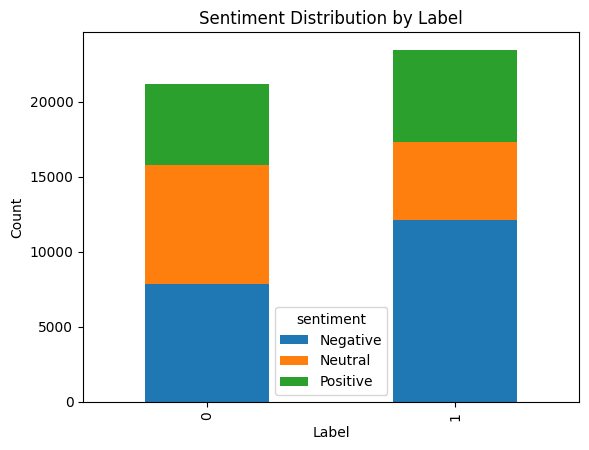

In [29]:
sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

A striking result is that the count of negative sentiments for fake news is higher than true news. This could indicate that the fake news are more likely to be sentimentally negative.

However, this is the same for the positive ones. The neutral sentiment is instead higher in true news, which suggests that the true news are more likely to be just conveying the real fact instead of an opinion based on it.

This concludes the EDA part of the project. Next, we will work on understanding the underlying connections between the data, what features we could extract from it, and how we can use them to create our models.

# Feature Engineering

This section will cover some of the most important steps in feature engineering. We will start with the cleaning and preprocessing of the text data, and then move on to feature engineering.

For the transformer model we will use later, we actually don't need to do all of this cleanup, so we are going to create once more a new dataset to use for classical ML models.

In [30]:
from scripts.clean_text_features import clean_text
from scripts.spacy_features import parallelize_dataframe, process_chunk

We know that, in general, fake news is riddled with [absurd statements](https://en.wikipedia.org/wiki/Fake_news#Defining_fake_news). Which might hide some truth underneath, but are really just meant to stir up controversy.

We already obtained the sentiment analysis from the previous section. Let's add some more features to the dataset. 

Other things we can check for are: 

- The polarity of the text;
- The subjectivity of the text;
- The usage of emotional words;
- We saw the words 'north', 'russia' and 'china' in the top 10 of the fake news set. Let's add a count for those and other big adjectives.

In [31]:
import re

df_2['text'] = df_2['text'].apply(lambda x: re.sub(r'^\s*[A-Z]+\s*\(\s*[A-Za-z\s]*Reuters\)\s*-\s*', '', x))

df_2['exclamation_count'] = df_2['text'].str.count('!')
df_2['capital_count'] = df_2['text'].str.count(r'[A-Z]')
df_2['question_count'] = df_2['text'].str.count(r'\?')

keywords = ['china', 'north korea', 'fake news', 'scandal', 'conspiracy']
for keyword in keywords:
    df_2[f'{keyword}_count'] = df_2['text'].str.lower().str.count(keyword)

df_2

,title,text,subject,date,token_count,word_count,sentence_count,label,exclamation_count,capital_count,question_count,china_count,north korea_count,fake news_count,scandal_count,conspiracy_count
0,Fox News Confuses Julius Caesar Depiction For...,Fox News loves to point the finger at Snowfla...,General News,2017-06-12,349,320,17,1,0,78,3,0,0,0,0,0
1,BOMBSHELL: US General Admits Obama Willingly A...,The idea that our President would arm terroris...,Politics,2015-11-01,300,268,15,1,0,99,5,0,0,0,0,0
2,Armed Black Protesters Chase Off Anti-Muslim ...,This is either really funny or a dangerous esc...,General News,2016-04-02,448,411,22,1,0,80,0,0,0,0,0,0
3,HUMILIATING: Democrats Use RUSSIAN WARSHIPS As...,Maybe Hillary s Russian uranium deal included ...,Politics,2016-07-29,368,336,23,1,0,81,1,0,0,0,0,0
4,No. 2 Senate Republican: health bill to be dis...,"Senator John Cornyn, the No. 2 Senate Republic...",Politics,2017-07-24,80,69,4,0,0,19,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44674,Trump White House Wishes ‘Lasting Peach’ In T...,"Donald Trump hires all the best people, at lea...",General News,2017-05-22,423,367,17,1,0,80,0,0,0,0,0,0
44675,WOW! IS SEAN HANNITY’S Job With FOX News In Je...,"What the heck is going on over at FOX News, th...",Politics,2017-05-23,1146,985,48,1,13,363,6,0,0,1,0,1
44676,BREAKING DALLAS: DPD Chief Confirms 10 Officer...,UPDATE 12:09: 1 Suspect in custody. 1 suspect ...,Politics,2016-07-07,499,378,40,1,5,306,0,0,0,0,0,0
44677,Trump's concession on wall funding removes obs...,The threat of a U.S. government shutdown this ...,Politics,2017-04-25,940,829,42,0,0,144,0,0,0,0,0,0


Now we can start the feature engineering. Nowadays, we have powerful tools that can help us automate all of these processes, such as the 'spacy' library. 

In [32]:
num_cores = 12 

df_2 = parallelize_dataframe(df_2, process_chunk, num_cores)
df_advanced_features = pd.json_normalize(df_2['advanced_features'])
df_2 = pd.concat([df_2, df_advanced_features], axis=1)

df_2.drop(columns=['advanced_features'], inplace=True)

In [33]:
df_2

,title,text,subject,date,token_count,word_count,sentence_count,label,exclamation_count,capital_count,...,conspiracy_count,flesch_reading_ease,gunning_fog,lexical_diversity,avg_word_length,avg_sentence_length,num_entities,noun_to_verb_ratio,positive_emotion_score,negative_emotion_score
0,Fox News Confuses Julius Caesar Depiction For...,Fox News loves to point the finger at Snowfla...,General News,2017-06-12,349,320,17,1,0,78,...,0,61.97,11.47,0.625000,4.730539,21.705882,36,1.439024,0.181818,0.121212
1,BOMBSHELL: US General Admits Obama Willingly A...,The idea that our President would arm terroris...,Politics,2015-11-01,300,268,15,1,0,99,...,0,55.44,10.50,0.615672,4.792727,23.153846,22,0.872340,0.145455,0.272727
2,Armed Black Protesters Chase Off Anti-Muslim ...,This is either really funny or a dangerous esc...,General News,2016-04-02,448,411,22,1,0,80,...,0,60.95,10.40,0.625304,4.633110,22.863636,26,1.642857,0.134921,0.206349
3,HUMILIATING: Democrats Use RUSSIAN WARSHIPS As...,Maybe Hillary s Russian uranium deal included ...,Politics,2016-07-29,368,336,23,1,0,81,...,0,63.70,10.34,0.678571,4.765537,20.947368,41,1.511111,0.234375,0.156250
4,No. 2 Senate Republican: health bill to be dis...,"Senator John Cornyn, the No. 2 Senate Republic...",Politics,2017-07-24,80,69,4,0,0,19,...,0,49.15,13.04,0.803030,4.761194,37.000000,13,2.000000,0.125000,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44674,Trump White House Wishes ‘Lasting Peach’ In T...,"Donald Trump hires all the best people, at lea...",General News,2017-05-22,423,367,17,1,0,80,...,0,65.15,11.56,0.689373,4.616188,25.588235,38,1.704545,0.227273,0.151515
44675,WOW! IS SEAN HANNITY’S Job With FOX News In Je...,"What the heck is going on over at FOX News, th...",Politics,2017-05-23,1146,985,48,1,13,363,...,1,60.04,10.00,0.477157,4.623314,20.928571,123,1.588235,0.212903,0.174194
44676,BREAKING DALLAS: DPD Chief Confirms 10 Officer...,UPDATE 12:09: 1 Suspect in custody. 1 suspect ...,Politics,2016-07-07,499,378,40,1,5,306,...,0,50.33,8.09,0.621693,5.987685,22.318182,69,2.236842,0.083333,0.183333
44677,Trump's concession on wall funding removes obs...,The threat of a U.S. government shutdown this ...,Politics,2017-04-25,940,829,42,0,0,144,...,0,57.30,12.31,0.536320,4.845169,29.212121,109,1.652542,0.210938,0.125000


In [34]:
df_2['text'][9167]

'At least six people were killed on Tuesday when a suicide car bomb ripped through a base used by a local security force in Yemen s southern port city of Aden, residents said, in an attack claimed by Islamic State. Dozens of other people, including civilians, were wounded in the attack, which occurred outside a camp used by a local security force organized by the Saudi-led coalition fighting Yemen s Houthi rebels. Islamist militants have exploited a civil war that began in 92015 to try to expand their influence and gain a foothold in the impoverished country located in the southern Arabian Peninsula, near the world s top oil exporter, Saudi Arabia. Witnesses described a huge explosion that shook the al-Mansoura district in northern Aden, destroying at least one building and shattering windows in others. A plume of smoke rose over the area. Ambulances raced to the scene to evacuate the wounded. Pictures circulating on social media showed several young men in military uniform being carri

In [35]:
df_2['text'] = df_2['text'].apply(clean_text)
df_2['text']

0        fox news loves to point the finger at snowflak...
1        the idea that our president would arm terroris...
2        this is either really funny or a dangerous esc...
3        maybe hillary s russian uranium deal included ...
4        senator john cornyn the no senate republican s...
                               ...                        
44674    donald trump hires all the best people at leas...
44675    what the heck is going on over at fox news the...
44676    update suspect in custody suspect pinned down ...
44677    the threat of a u s government shutdown this w...
44678    faced with a growing test of resolve for a new...
Name: text, Length: 44679, dtype: object

In [36]:
df_2['text'][9167]

'at least six people were killed on tuesday when a suicide car bomb ripped through a base used by a local security force in yemen s southern port city of aden residents said in an attack claimed by islamic state dozens of other people including civilians were wounded in the attack which occurred outside a camp used by a local security force organized by the saudi led coalition fighting yemen s houthi rebels islamist militants have exploited a civil war that began in to try to expand their influence and gain a foothold in the impoverished country located in the southern arabian peninsula near the world s top oil exporter saudi arabia witnesses described a huge explosion that shook the al mansoura district in northern aden destroying at least one building and shattering windows in others a plume of smoke rose over the area ambulances raced to the scene to evacuate the wounded pictures circulating on social media showed several young men in military uniform being carried away residents sa

In [37]:
df_2['title'] = df_2['title'].apply(clean_text)
df_2['title']

0         fox news confuses julius caesar depiction for...
1        bombshell us general admits obama willingly ar...
2         armed black protesters chase off anti muslim ...
3        humiliating democrats use russian warships as ...
4        no senate republican health bill to be discuss...
                               ...                        
44674     trump white house wishes lasting peach in the...
44675    wow is sean hannity s job with fox news in jeo...
44676    breaking dallas dpd chief confirms officers sh...
44677    trump s concession on wall funding removes obs...
44678    facing test of resolve trump pushes ahead with...
Name: title, Length: 44679, dtype: object

Ok, our words are all cleaned. We can now proceed with further understanding the data.

In [38]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44679 entries, 0 to 44678
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   title                   44679 non-null  object        
 1   text                    44679 non-null  object        
 2   subject                 44679 non-null  object        
 3   date                    44679 non-null  datetime64[ns]
 4   token_count             44679 non-null  int64         
 5   word_count              44679 non-null  int64         
 6   sentence_count          44679 non-null  int64         
 7   label                   44679 non-null  int64         
 8   exclamation_count       44679 non-null  int64         
 9   capital_count           44679 non-null  int64         
 10  question_count          44679 non-null  int64         
 11  china_count             44679 non-null  int64         
 12  north korea_count       44679 non-null  int64 

Let's create a correlation matrix to check how the features interact with each others.

In [ ]:
stop

In [39]:
df_matrix = df_2.copy()

In [ ]:
stop

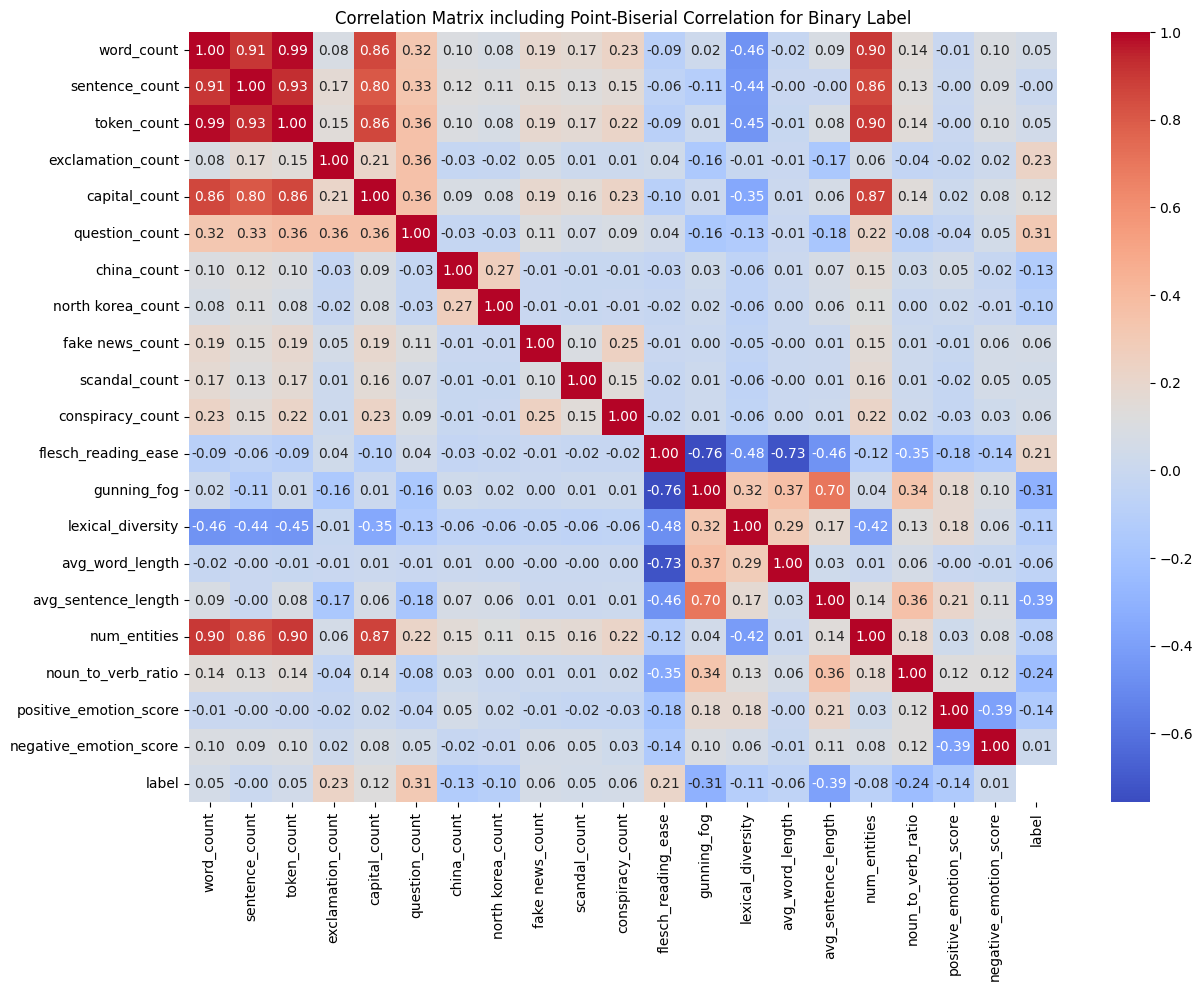

In [42]:
from scipy.stats import pointbiserialr

numerical_features = ['word_count', 'sentence_count', 'token_count', 'exclamation_count', 'capital_count',
                      'question_count', 'china_count', 'north korea_count', 'fake news_count',
                      'scandal_count', 'conspiracy_count', 'flesch_reading_ease', 'gunning_fog',
                      'lexical_diversity', 'avg_word_length', 'avg_sentence_length', 'num_entities',
                      'noun_to_verb_ratio', 'positive_emotion_score', 'negative_emotion_score']

df_numeric = df_matrix[numerical_features + ['label']]
corr_matrix = df_numeric.corr()

point_biserial_corr = {}
for feature in numerical_features:
    corr, _ = pointbiserialr(df_numeric[feature], df_numeric['label'])
    point_biserial_corr[feature] = corr

corr_matrix.loc['label'] = pd.Series(point_biserial_corr)
corr_matrix['label'] = pd.Series(point_biserial_corr)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix including Point-Biserial Correlation for Binary Label')
plt.show()

We can see some interesting negative influences of:
- the 'gunning fog' and 'avg_sentence_length' on the label. 
- the average word length and the gunning fog score on the flesch reading ease

Some of the interesting positive influences are:
- The flesch reading ease and the question and exclamation counts towards the label;
- The count of the word 'conspiracy' with the count of 'fake_news';

Other interesting relations:
- The positive_emotion_score (-0.14) respective to the label.

##### Insights:

- Simpler, Easier-to-Read Texts: There is a trend showing that articles with simpler readability (higher Flesch scores, lower Gunning Fog scores, shorter sentences) correlate with the positive label.

- Sensationalism Indicators: Features like exclamation_count and question_count are positively correlated with the label, which could suggest that more sensationalist writing styles are associated with one class over the other.

- There is a huge multicollinearity issue with token, sentence and word count measures. We should deal with this, and we will do so by keeping only the token count. This also correlates highly with the number of entities, which needs to be more specific.

In [46]:
df_final = df_2.drop(columns=['num_entities','sentence_count', 'word_count'])

df_final.to_csv(f'{data_dir}/elaborated_data.csv', index=False)

df_final = pd.read_csv(f'{data_dir}/elaborated_data.csv')

# Classical ML Models

After understanding the relationships of the data within each other, and what the underlying relationships tell us, we can now proceed with training our first 2 classical ML models.

In our case, since we have computational power to do so, we are going to train more than 2 models and see the results. 

Then, we are going to compare them together and finally understand where their predictions are going wrong.

In [48]:
from sklearn.model_selection import train_test_split

train_val_df = df_final[df_final['date'] < '2017-09']
test_df = df_final[df_final['date'] >= '2017-09']

X_train, X_val, y_train, y_val = train_test_split(train_val_df.drop(columns=['label', 'date']),
                                                  train_val_df['label'],
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=train_val_df['subject'])

X_test = test_df.drop(columns=['label', 'title', 'date'])
y_test = test_df['label']

print(f"Train set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

Train set size: (24574, 22)
Validation set size: (6144, 22)
Test set size: (13961, 21)


As mentioned before, we had 2 choices to split our data. The most reasonable one, for a model that should work in the real world as well, is to define a cut-off date. We chose a cut-off date that is at least 3 months before the end of the dataset, which avoids data leakage but makes the test set very big.

This is not a concern, we have plenty of data to train our model on, so having a large test set might actually be beneficial if our training goes smoothly.

In [49]:
print("Train set label distribution:")
print(y_train.value_counts(normalize=True) * 100)

print("\nValidation set label distribution:")
print(y_val.value_counts(normalize=True) * 100)

print("\nTest set label distribution:")
print(y_test.value_counts(normalize=True) * 100)

Train set label distribution:
label
1    69.186946
0    30.813054
Name: proportion, dtype: float64

Validation set label distribution:
label
1    68.701172
0    31.298828
Name: proportion, dtype: float64

Test set label distribution:
label
0    83.91949
1    16.08051
Name: proportion, dtype: float64


Clearly, in our test set we have a much higher concentration of true labels than the other two. To avoid overfitting, we will use a stratified split, as well as using class weights in the models we are going to fit.

Let's define the pipeline for our models. Since we have both numerical and categorical columns, we need to apply preprocessing steps such as StandardScaler and OneHotEncoder. 

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['subject']
text_features = 'text'

def replace_inf_values(X):
    "If values of x are inf, replace them with nan"
    return np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('scaler', StandardScaler())]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('text', TfidfVectorizer(max_features=5000), text_features)
    ])

In [51]:
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):
    
    model_name = trial.suggest_categorical('model', ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'])
    
    if model_name == 'LogisticRegression':
        classifier = LogisticRegression(
            max_iter=trial.suggest_int('max_iter', 100, 1000),
            C=trial.suggest_loguniform('C', 1e-4, 1e4),
            class_weight='balanced'
        )
    elif model_name == 'DecisionTreeClassifier':
        classifier = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            class_weight='balanced'
        )
    else:
        classifier = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 200),
            max_depth=trial.suggest_int('max_depth', 1, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            class_weight='balanced'
        )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)
print("Best AUC Score: ", study.best_value)

[I 2024-09-03 12:56:57,291] A new study created in memory with name: no-name-29fca149-0cb1-4022-9350-d37504b52042
[I 2024-09-03 12:57:24,147] Trial 0 finished with value: 0.9477316879929403 and parameters: {'model': 'DecisionTreeClassifier', 'max_depth': 12, 'min_samples_split': 6}. Best is trial 0 with value: 0.9477316879929403.
[I 2024-09-03 12:57:37,470] Trial 1 finished with value: 0.9986567669292888 and parameters: {'model': 'LogisticRegression', 'max_iter': 773, 'C': 728.4422157184651}. Best is trial 1 with value: 0.9986567669292888.
[I 2024-09-03 12:58:07,698] Trial 2 finished with value: 0.9965818580622874 and parameters: {'model': 'RandomForestClassifier', 'n_estimators': 108, 'max_depth': 12, 'min_samples_split': 5}. Best is trial 1 with value: 0.9986567669292888.
[I 2024-09-03 12:58:13,990] Trial 3 finished with value: 0.9545167212990344 and parameters: {'model': 'LogisticRegression', 'max_iter': 935, 'C': 0.003866223217322438}. Best is trial 1 with value: 0.9986567669292888

Best hyperparameters:  {'model': 'LogisticRegression', 'max_iter': 269, 'C': 182.35360614361426}
Best AUC Score:  0.9989859532784534


In [52]:
best_trials = sorted(study.trials, key=lambda x: x.value, reverse=True)[:2]

for idx, trial in enumerate(best_trials):
    best_params = trial.params.copy()
    best_model_name = best_params.pop('model')
    
    if best_model_name == 'LogisticRegression':
        best_model = LogisticRegression(**best_params)
    elif best_model_name == 'DecisionTreeClassifier':
        best_model = DecisionTreeClassifier(**best_params)
    else:
        best_model = RandomForestClassifier(**best_params)
    
    best_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', best_model)
    ])
    
    best_pipeline.fit(X_train, y_train)
    
    y_val_pred = best_pipeline.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_pred)
    
    y_test_pred = best_pipeline.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    print(f"Model {idx + 1}: {best_model_name}")
    print("Best hyperparameters: ", best_params)
    print(f"Validation Set AUC Score: {val_auc}")
    print(f"Test Set AUC Score: {test_auc}\n")

Model 1: LogisticRegression
Best hyperparameters:  {'max_iter': 269, 'C': 182.35360614361426}
Validation Set AUC Score: 0.9988692843141348
Test Set AUC Score: 0.9981051933624357

Model 2: LogisticRegression
Best hyperparameters:  {'max_iter': 317, 'C': 1133.4708453723758}
Validation Set AUC Score: 0.9988904744533776
Test Set AUC Score: 0.9983508741781175



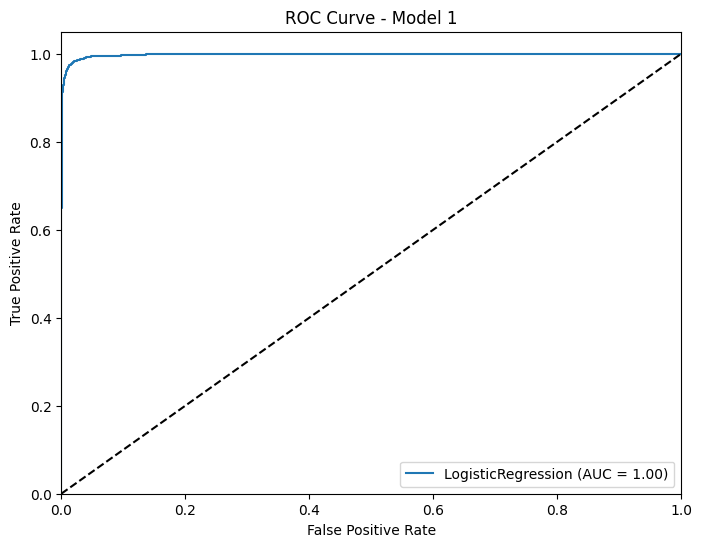

Model 1: LogisticRegression


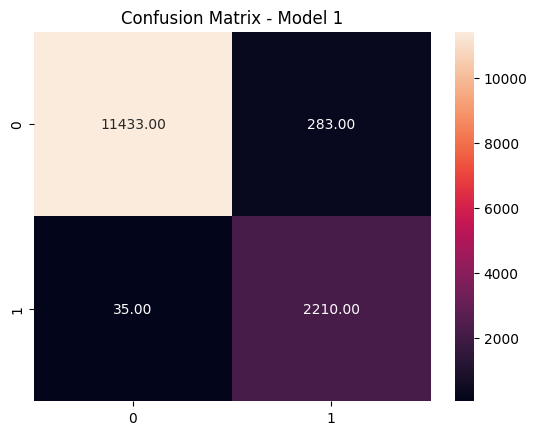

Classification Report - Model 1 (LogisticRegression):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11716
           1       0.89      0.98      0.93      2245

    accuracy                           0.98     13961
   macro avg       0.94      0.98      0.96     13961
weighted avg       0.98      0.98      0.98     13961



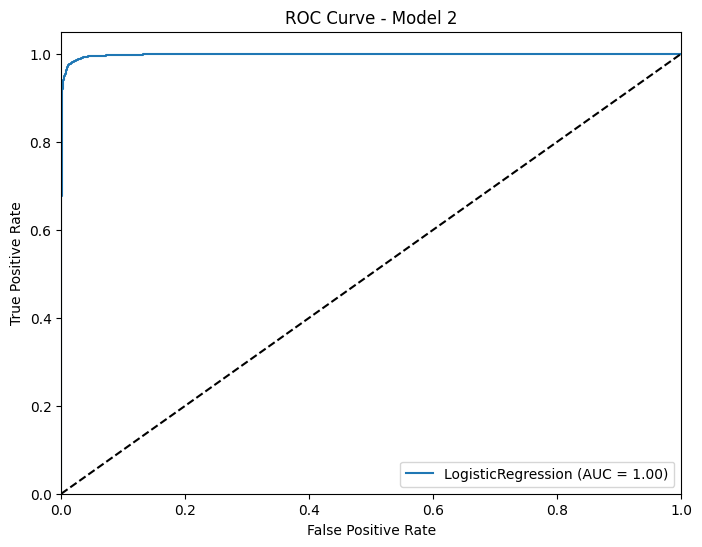

Model 2: LogisticRegression


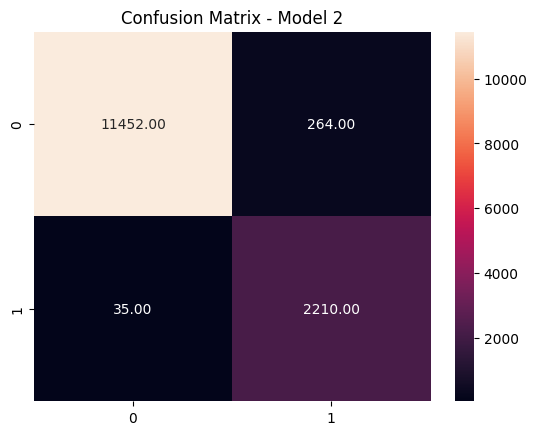

Classification Report - Model 2 (LogisticRegression):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11716
           1       0.89      0.98      0.94      2245

    accuracy                           0.98     13961
   macro avg       0.95      0.98      0.96     13961
weighted avg       0.98      0.98      0.98     13961



In [53]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

for idx, trial in enumerate(best_trials):
    best_params = trial.params.copy()
    best_model_name = best_params.pop('model')
    
    if best_model_name == 'LogisticRegression':
        best_model = LogisticRegression(**best_params)
    elif best_model_name == 'DecisionTreeClassifier':
        best_model = DecisionTreeClassifier(**best_params)
    else:
        best_model = RandomForestClassifier(**best_params)
    
    best_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', best_model)
    ])
    
    best_pipeline.fit(X_train, y_train)
    
    y_test_pred = best_pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_test_pred):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model {idx + 1}')
    plt.legend(loc="lower right")
    plt.show()

    corr = confusion_matrix(y_test, best_pipeline.predict(X_test))
    print(f"Model {idx + 1}: {best_model_name}")
    sns.heatmap(corr, annot=True, fmt="0.2f")
    plt.title(f'Confusion Matrix - Model {idx + 1}')
    plt.show()

    print(f'Classification Report - Model {idx + 1} ({best_model_name}):')
    print(classification_report(y_test, best_pipeline.predict(X_test)))

In [54]:
def get_feature_names(preprocessor, feature_names):
    output_feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns
        
        output_feature_names.extend(transformed_names)
    
    return output_feature_names

SHAP Analysis for Model 1 (LogisticRegression):


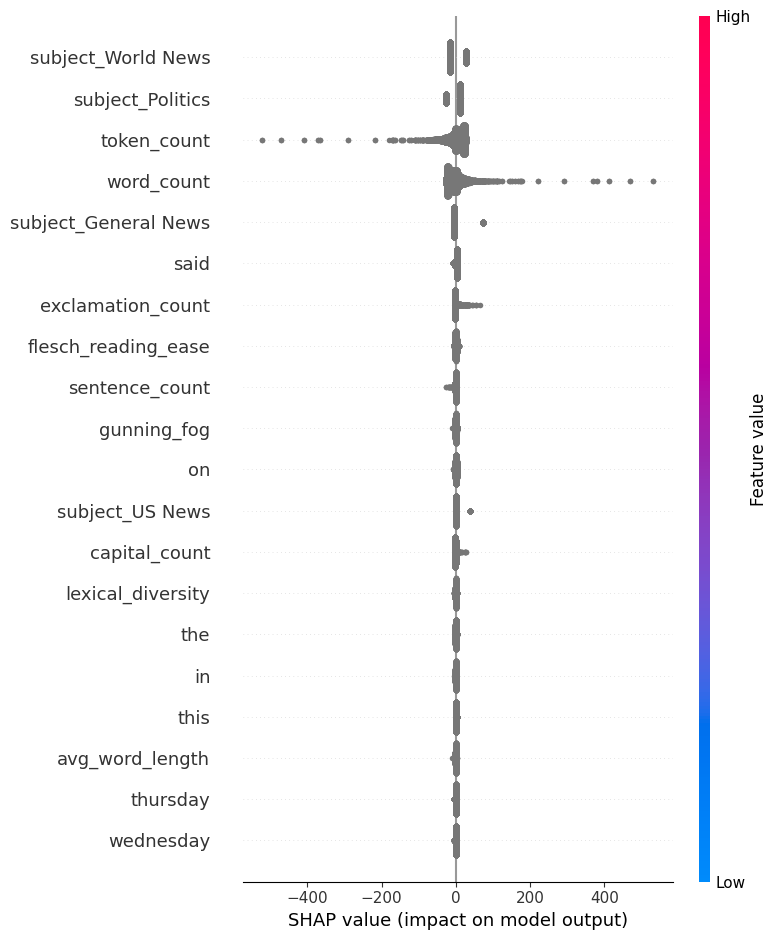

SHAP Analysis for Model 2 (LogisticRegression):


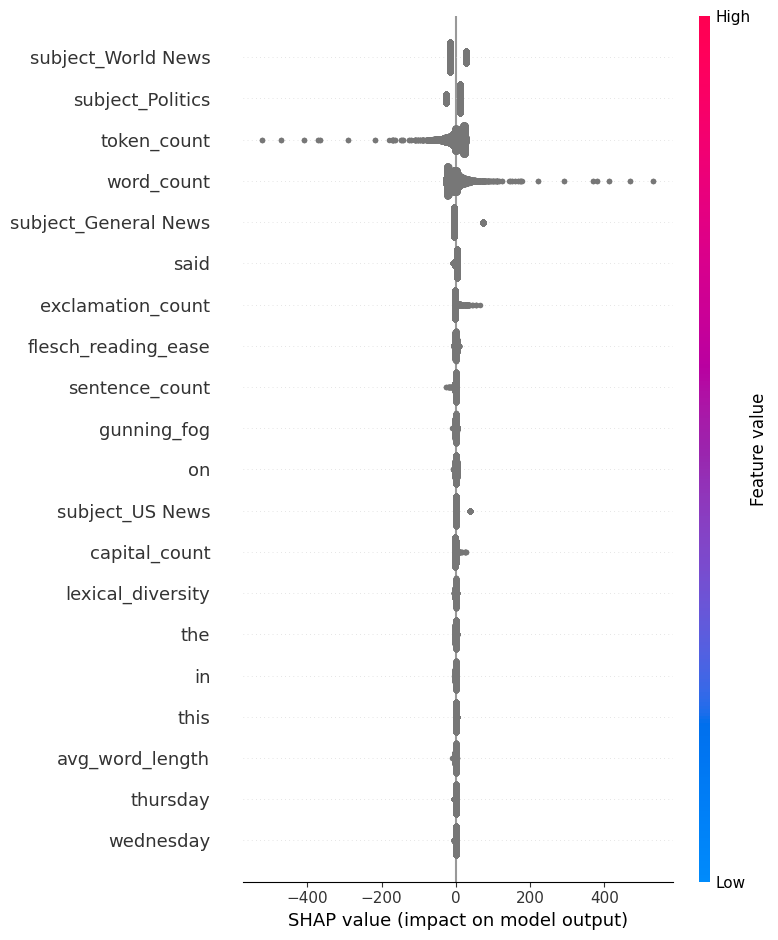

In [55]:
import shap

for idx, trial in enumerate(best_trials):
    best_params = trial.params.copy()
    best_model_name = best_params.pop('model')
    
    if best_model_name == 'LogisticRegression':
        best_model = LogisticRegression(**best_params)
    elif best_model_name == 'DecisionTreeClassifier':
        best_model = DecisionTreeClassifier(**best_params)
    else:
        best_model = RandomForestClassifier(**best_params)

    best_pipeline.fit(X_train, y_train)
    
    transformed_X_test = best_pipeline.named_steps['preprocessor'].transform(X_test)
    transformed_feature_names = get_feature_names(best_pipeline.named_steps['preprocessor'], X_test.columns)
    
    explainer = shap.Explainer(best_pipeline.named_steps['classifier'], transformed_X_test)
    shap_values = explainer(transformed_X_test)
    
    print(f"SHAP Analysis for Model {idx + 1} ({best_model_name}):")
    shap.summary_plot(shap_values, transformed_X_test, feature_names=transformed_feature_names)


In [56]:
y_test_pred_labels = best_pipeline.predict(X_test)
wrong_predictions_mask = (y_test != y_test_pred_labels)
wrong_predictions = X_test[wrong_predictions_mask]
wrong_actuals = y_test[wrong_predictions_mask]
wrong_predictions_labels = y_test_pred_labels[wrong_predictions_mask]

print(f"Number of Wrong Predictions: {len(wrong_predictions)}")

Number of Wrong Predictions: 299


In [57]:
wrong_df = pd.DataFrame({
    'Actual': wrong_actuals,
    'Predicted': wrong_predictions_labels,
    'Probability': best_pipeline.predict_proba(X_test)[:, 1][wrong_predictions_mask]
})

# Count wrong predictions by class
print("Wrong Predictions by Class:")
print(wrong_df.groupby(['Actual', 'Predicted']).size())

Wrong Predictions by Class:
Actual  Predicted
0       1            264
1       0             35
dtype: int64


Average Confidence of Wrong Predictions:
0.8215591666365256


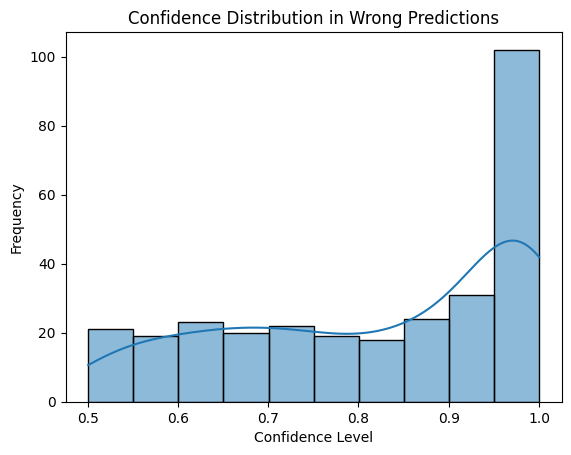

In [58]:
wrong_df['Confidence'] = wrong_df['Probability'].apply(lambda x: max(x, 1 - x))

print("Average Confidence of Wrong Predictions:")
print(wrong_df['Confidence'].mean())

sns.histplot(wrong_df['Confidence'], kde=True)
plt.title("Confidence Distribution in Wrong Predictions")
plt.xlabel("Confidence Level")
plt.ylabel("Frequency")
plt.show()

Comparison of Confidence Levels:
Average Confidence in Correct Predictions: 0.9910536403832892
Average Confidence in Wrong Predictions: 0.8215591666365256


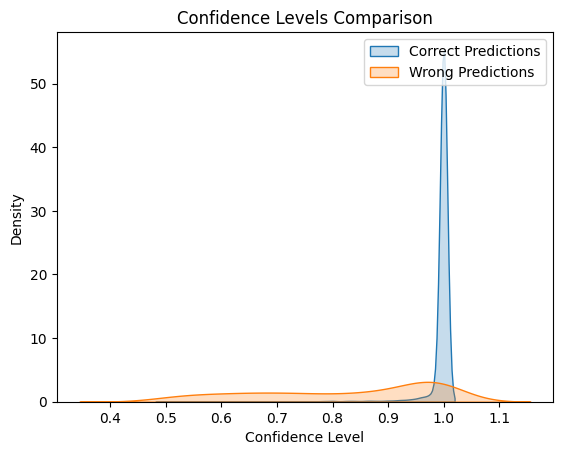

In [59]:
correct_predictions_mask = (y_test == y_test_pred_labels)
correct_predictions = X_test[correct_predictions_mask]
correct_actuals = y_test[correct_predictions_mask]
correct_predictions_labels = y_test_pred_labels[correct_predictions_mask]

correct_df = pd.DataFrame({
    'Actual': correct_actuals,
    'Predicted': correct_predictions_labels,
    'Probability': best_pipeline.predict_proba(X_test)[:, 1][correct_predictions_mask]
})

correct_df['Confidence'] = correct_df['Probability'].apply(lambda x: max(x, 1 - x))

print("Comparison of Confidence Levels:")
print("Average Confidence in Correct Predictions:", correct_df['Confidence'].mean())
print("Average Confidence in Wrong Predictions:", wrong_df['Confidence'].mean())

sns.kdeplot(correct_df['Confidence'], label='Correct Predictions', shade=True)
sns.kdeplot(wrong_df['Confidence'], label='Wrong Predictions', shade=True)
plt.title("Confidence Levels Comparison")
plt.xlabel("Confidence Level")
plt.ylabel("Density")
plt.legend()
plt.show()

In [60]:
wrong_predictions_mask = (y_test != y_test_pred_labels)
wrong_predictions = X_test[wrong_predictions_mask]
wrong_actuals = y_test[wrong_predictions_mask]
wrong_predictions_labels = y_test_pred_labels[wrong_predictions_mask]

wrong_transformed = best_pipeline.named_steps['preprocessor'].transform(wrong_predictions)

SHAP Summary for Correct Predictions:


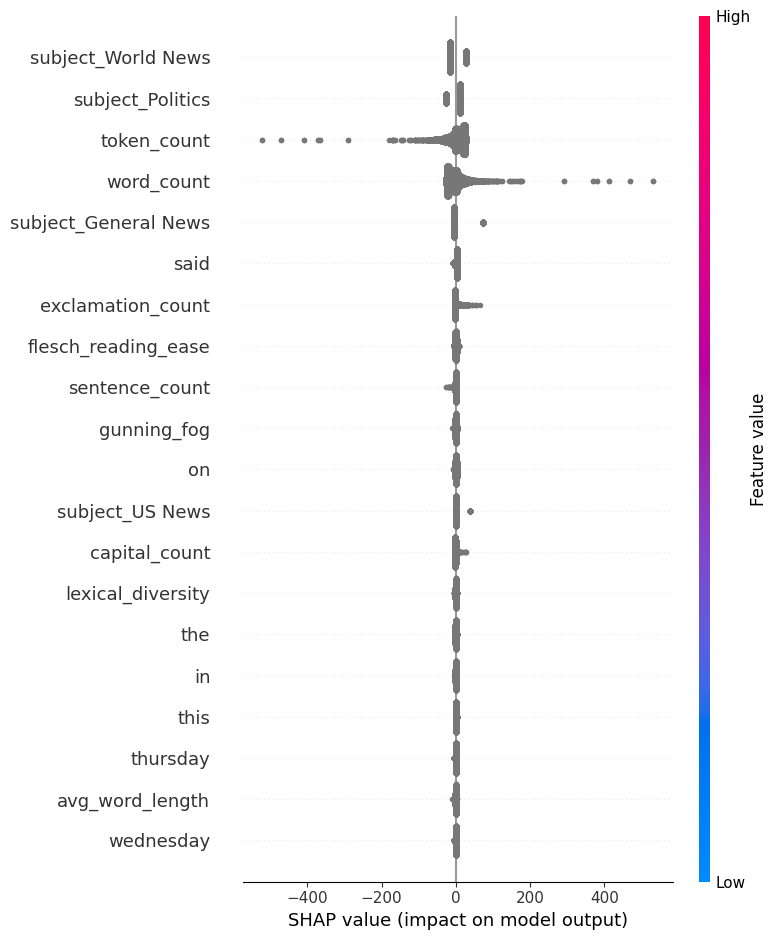

SHAP Summary for Wrong Predictions:


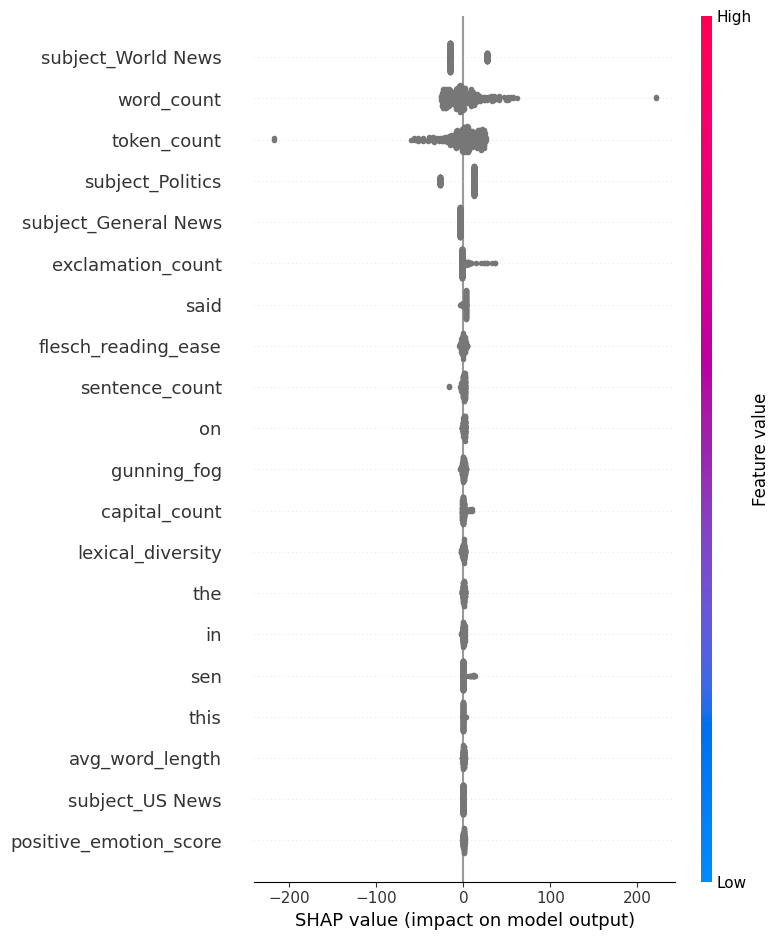

In [61]:
correct_transformed = best_pipeline.named_steps['preprocessor'].transform(correct_predictions)
correct_shap_values = explainer(correct_transformed)

wrong_shap_values = explainer(wrong_transformed)

print("SHAP Summary for Correct Predictions:")
shap.summary_plot(correct_shap_values, correct_transformed, feature_names=transformed_feature_names)

print("SHAP Summary for Wrong Predictions:")
shap.summary_plot(wrong_shap_values, wrong_transformed, feature_names=transformed_feature_names)

In [62]:
for i in range(min(5, len(wrong_predictions))):
    print(f"Case {i + 1}")
    print(f"Actual: {wrong_actuals.iloc[i]}, Predicted: {wrong_predictions_labels[i]}")
    print(wrong_predictions.iloc[i])
    print()

Case 1
Actual: 0, Predicted: 1
text                      helen kwambana has lived in fear of zimbabwean...
subject                                                          World News
token_count                                                             482
word_count                                                              442
sentence_count                                                           20
exclamation_count                                                         1
capital_count                                                            57
question_count                                                            0
china_count                                                               0
north korea_count                                                         0
fake news_count                                                           0
scandal_count                                                             0
conspiracy_count                                         

We determined that the best model within our classical machine learning ones is a Logistic Regression, which has a final ROC AUC score of 0.997 on the test set.

The results are pretty good, with only 48 false negatives, and 386 false positives over a total of 13961 samples. 

# Deep Learning Model

Now we are going to build upon the current data we built up until now, to build a deep learning model.

This has to be an end-to-end model that can be used to detect fake news.